In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Задание 1
На основании датасета для каждого покупателя получите:
- предпочитаемый метод оплаты; 
- общие траты;
- количество денег, потраченных на дополнительные услуги и аксессуары. 


In [2]:
data = pd.read_csv('Electronic_sales_Sep2023-Sep2024.csv')

In [3]:
print(data['Order Status'].unique())

['Cancelled' 'Completed']


In [4]:
# Фильтруем только завершённые заказы
df_completed = data[data['Order Status'] == 'Completed'].copy()

In [5]:
result = df_completed.groupby('Customer ID').agg({
    'Payment Method': lambda x: x.value_counts().idxmax(),
    'Total Price': 'sum',
    'Add-on Total': 'sum',
})

In [6]:
rename_dict = {
    'Payment Method': 'Payment Method Preference',
    'Total Price': 'Total expenses',
    'Add-on Total': 'Total add-on expenses'
}

result.rename(columns=rename_dict, inplace=True)


### Результат
На основании датасета для каждого покупателя получены:
- предпочитаемый метод оплаты (поле Payment Method Preference); 
- общие траты (поле Total expenses);
- количество денег, потраченных на дополнительные услуги и аксессуары (поле Total add-on expenses) 

При расчете учитывались только заказы в статусе Completed.


In [7]:
result.head(10)

,Payment Method Preference,Total expenses,Total add-on expenses
Customer ID,,,
1000,Paypal,741.09,26.09
1002,Credit Card,5020.60,60.16
1003,Cash,41.50,35.56
1004,Credit Card,83.00,65.78
1005,Paypal,11779.11,75.33
1006,Cash,6645.94,90.38
1008,Cash,3379.32,65.85
1011,Credit Card,7911.90,70.17
1014,Cash,4747.14,8.30


## Задание 2
1. На основании датасета получите доход:
- по каждому методу доставки, 
- по каждому типу продукта, 
- по дополнительным услугам за каждый месяц,
- по дополнительным услугам за каждый квартал. 
2. Отобразите полученные данные на графике.


In [8]:
# Приводим дату к формату datetime
df_completed['Purchase Date'] = pd.to_datetime(df_completed['Purchase Date'])


In [9]:
# Считаем доход как сумму основной цены и доп. услуг
df_completed['Income'] = (df_completed['Total Price'] + df_completed['Add-on Total'])

#### Доход по методу доставки

In [10]:
income_by_shipping = (
    df_completed.groupby('Shipping Type')['Income']
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)
income_by_shipping.head()


,Shipping Type,Income
0,Standard,14676351.95
1,Expedited,8610437.09
2,Same Day,8469574.60
3,Overnight,5982983.40
4,Express,5725863.77


#### Доход по типу продукта

In [11]:
income_by_product = (
    df_completed.groupby('Product Type')['Income']
    .sum()
    .sort_values(ascending=False)
    .reset_index()

)
income_by_product

,Product Type,Income
0,Smartphone,14630325.53
1,Smartwatch,9557416.02
2,Laptop,8536583.03
3,Tablet,7893431.51
4,Headphones,2847454.72


#### Доход по доп. услугам (помесячно)

In [12]:
income_addon_month = (
    df_completed.groupby(df_completed['Purchase Date'].dt.to_period('M'))['Add-on Total']
    .sum()
    .rename_axis('Month')
    .reset_index()
)
income_addon_month['Month'] = income_addon_month['Month'].astype(str)
income_addon_month

,Month,Add-on Total
0,2023-09,5337.61
1,2023-10,26153.21
2,2023-11,24453.33
3,2023-12,22750.23
4,2024-01,93254.95
5,2024-02,80253.72
6,2024-03,84713.93
7,2024-04,82294.06
8,2024-05,89374.18
9,2024-06,84648.60


#### Доход по доп. услугам (поквартально)

In [13]:
income_addon_quarter = (
    df_completed.groupby(df_completed['Purchase Date'].dt.to_period('Q'))['Add-on Total']
    .sum()
    .rename_axis('Quarter')
    .reset_index()
)
income_addon_quarter['Quarter'] = income_addon_quarter['Quarter'].astype(str)
income_addon_quarter

,Quarter,Add-on Total
0,2023Q3,5337.61
1,2023Q4,73356.77
2,2024Q1,258222.60
3,2024Q2,256316.84
4,2024Q3,242361.42


#### Визуализация данных по доходам

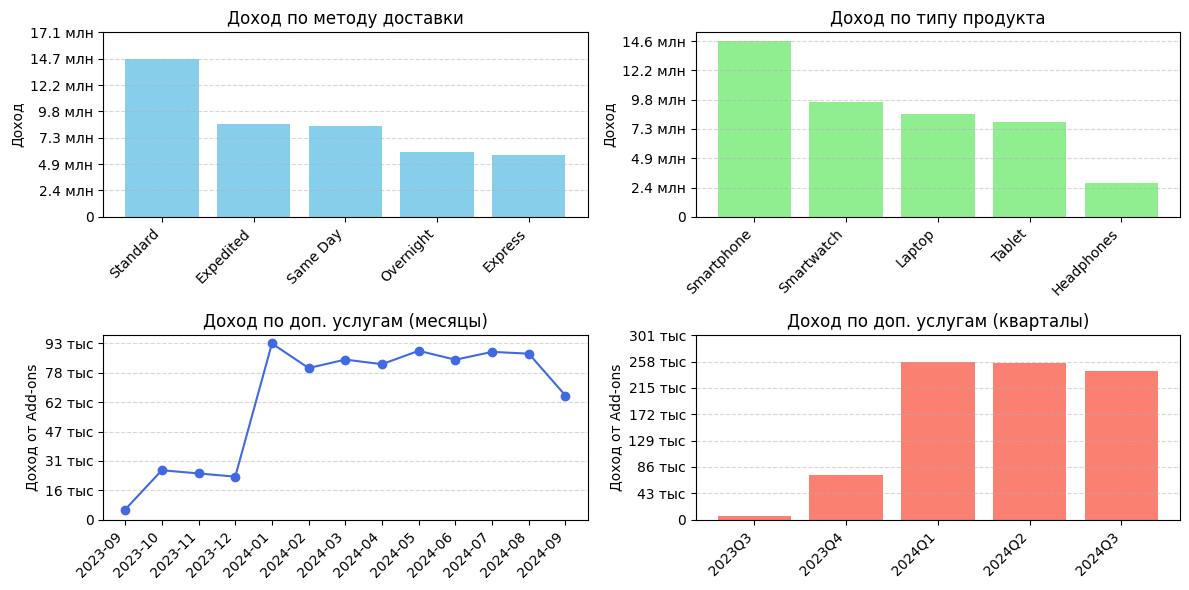

In [14]:
# вспомогательная функция для форматирования чисел в млн / тыс
def format_millions(x):
    if x >= 1_000_000:
        return f"{x/1_000_000:.1f} млн"
    elif x >= 1_000:
        return f"{x/1_000:.0f} тыс"
    else:
        return str(int(x))

plt.figure(figsize=(12, 6))

# Доход по методу доставки
plt.subplot(2, 2, 1)
plt.bar(income_by_shipping['Shipping Type'], income_by_shipping['Income'], color='skyblue')
plt.title('Доход по методу доставки')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Доход')
plt.grid(axis='y', linestyle='--', alpha=0.5)

ymax = income_by_shipping['Income'].max()
step = ymax / 6
yticks = np.arange(0, ymax + step, step)
plt.yticks(yticks, [format_millions(y) for y in yticks])

# Доход по типу продукта
plt.subplot(2, 2, 2)
plt.bar(income_by_product['Product Type'], income_by_product['Income'], color='lightgreen')
plt.title('Доход по типу продукта')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Доход')
plt.grid(axis='y', linestyle='--', alpha=0.5)

ymax = income_by_product['Income'].max()
step = ymax / 6
yticks = np.arange(0, ymax + step, step)
plt.yticks(yticks, [format_millions(y) for y in yticks])

# Доход по доп. услугам (помесячно)
plt.subplot(2, 2, 3)
plt.plot(income_addon_month['Month'], income_addon_month['Add-on Total'], marker='o', color='royalblue')
plt.title('Доход по доп. услугам (месяцы)')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Доход от Add-ons')
plt.grid(axis='y', linestyle='--', alpha=0.5)

ymax = income_addon_month['Add-on Total'].max()
step = ymax / 6
yticks = np.arange(0, ymax + step, step)
plt.yticks(yticks, [format_millions(y) for y in yticks])

# Доход по доп. услугам (поквартально)
plt.subplot(2, 2, 4)
plt.bar(income_addon_quarter['Quarter'], income_addon_quarter['Add-on Total'], color='salmon')
plt.title('Доход по доп. услугам (кварталы)')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Доход от Add-ons')
plt.grid(axis='y', linestyle='--', alpha=0.5)

ymax = income_addon_quarter['Add-on Total'].max()
step = ymax / 6
yticks = np.arange(0, ymax + step, step)
plt.yticks(yticks, [format_millions(y) for y in yticks])

plt.tight_layout()
plt.show()


### Результат
1. На основании датасета получен доход:
- по каждому методу доставки, 
- по каждому типу продукта, 
- по дополнительным услугам за каждый месяц,
- по дополнительным услугам за каждый квартал. 
2.  Полученные данные отображены на графике.

При расчете учитывались только заказы в статусе Completed.